## Problem 5



#### a) Create a Robotarium simulation based on consensus over displacements that achieves the formation

#### The following code shows that the 7 agents converge to the desired formation based on the consensus over displacements, no matter what the initial condition is.

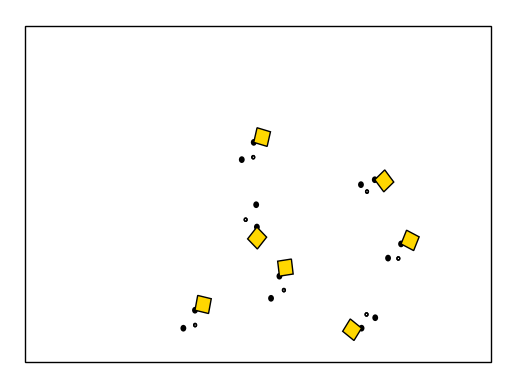

Initial positions reached
##### DEBUG OUTPUT #####
Your simulation will take approximately 49 real seconds when deployed on the Robotarium. 

	 Simulation had 373 iteration(s) where robots collided.



<Figure size 640x480 with 0 Axes>

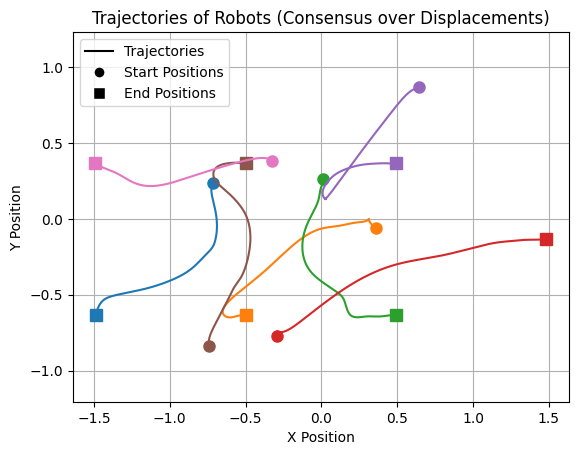

In [2]:
# Import necessary Robotarium utilities and other libraries
import numpy as np
from rps.robotarium import Robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.controllers import *
from rps.utilities.misc import *
import matplotlib.pyplot as plt  # Import for visualization

# Number of agents
N = 7
dt = 0.01  # Numerical step length
max_iter = 1000
videoFlag = False  # Change to True to record video
circularInitialConditions = False  # Change to False for random initial conditions

# Initialize the Robotarium object
rbtm = Robotarium(number_of_robots=N, show_figure=True)

# Create single integrator to unicycle dynamics mapping and barrier certificates
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Control parameters
formation_control_gain = 1.0
max_vel = 0.1  # Maximum velocity for safety

# Initialize robots' positions
xuni = rbtm.get_poses()  # States of real unicycle robots
x = xuni[:2, :]  # x-y positions only

# Assign dummy zero velocity
rbtm.set_velocities(np.arange(N), np.zeros((2, N)))
rbtm.step()

# Define edges based on the formation graph (adjusted for zero-based indexing)
edges = [
    (0, 1),  # Agents 1 and 2
    (1, 2),  # Agents 2 and 3
    (2, 3),  # Agents 3 and 4
    (3, 4),  # Agents 4 and 5
    (4, 5),  # Agents 5 and 6
    (5, 6),  # Agents 6 and 7
    (6, 0)   # Agents 7 and 1
]

# Define desired displacements for each edge (without using absolute positions)
desired_displacements = {}

# Manually specify the desired displacements between connected agents
# These are the x and y components of the desired displacements

# Edge between Agent 1 and Agent 2
desired_displacements[(0, 1)] = np.array([1, 0])
desired_displacements[(1, 0)] = -desired_displacements[(0, 1)]

# Edge between Agent 2 and Agent 3
desired_displacements[(1, 2)] = np.array([1, 0])
desired_displacements[(2, 1)] = -desired_displacements[(1, 2)]

# Edge between Agent 3 and Agent 4
desired_displacements[(2, 3)] = np.array([1, 0.5])
desired_displacements[(3, 2)] = -desired_displacements[(2, 3)]

# Edge between Agent 4 and Agent 5
desired_displacements[(3, 4)] = np.array([-1, 0.5])
desired_displacements[(4, 3)] = -desired_displacements[(3, 4)]

# Edge between Agent 5 and Agent 6
desired_displacements[(4, 5)] = np.array([-1, 0])
desired_displacements[(5, 4)] = -desired_displacements[(4, 5)]

# Edge between Agent 6 and Agent 7
desired_displacements[(5, 6)] = np.array([-1, 0])
desired_displacements[(6, 5)] = -desired_displacements[(5, 6)]

# Edge between Agent 7 and Agent 1
desired_displacements[(6, 0)] = np.array([0, -1])
desired_displacements[(0, 6)] = -desired_displacements[(6, 0)]

# Define adjacency matrix
Adj = np.zeros((N, N), dtype=bool)
for (i, j) in edges:
    Adj[i, j] = True
    Adj[j, i] = True

# Initialize positions on a circle if required
if circularInitialConditions:
    angles = np.linspace(0, 2 * np.pi * (1 - 1 / N), N)
    initial_positions = np.vstack((np.cos(angles), np.sin(angles)))
else:
    initial_positions = np.random.rand(2, N) * 2 - 1  # Random positions in [-1, 1]

# Move robots to initial positions
errorToInitialPos = x - initial_positions
errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
while np.max(errorNorm) > 0.05:
    # Update state variables
    xuni = rbtm.get_poses()
    x = xuni[:2, :]
    # Update errors
    errorToInitialPos = x - initial_positions
    errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
    # Compute control inputs
    u = -0.3 * errorToInitialPos
    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]
    # Map single integrator velocities to unicycle velocities
    dx = si_to_uni_dyn(u, xuni)
    # Assign new control inputs to robots
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()
print('Initial positions reached')

# Initialize array to record positions
positions = np.zeros((2, N, max_iter))

# Main loop for formation control
for k in range(max_iter):
    # Get new data and initialize new null velocities
    xuni = rbtm.get_poses()  # Get new robots' states
    x = xuni[:2, :]  # Extract single integrator states
    u = np.zeros((2, N))  # Initialize velocities to zero

    # Record positions at this time step
    positions[:, :, k] = x

    # Formation control algorithm using consensus over displacements
    for i in range(N):
        neighbors = np.where(Adj[i, :])[0]
        for j in neighbors:
            # Compute the error between actual and desired displacement
            actual_displacement = x[:, j] - x[:, i]
            desired_displacement = desired_displacements[(i, j)]
            error = actual_displacement - desired_displacement
            u[:, i] += formation_control_gain * error

    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]

    # Use barrier certificates to avoid collisions
    u = si_barrier_cert(u, x)

    # Convert single integrator inputs to unicycle inputs
    dx = si_to_uni_dyn(u, xuni)

    # Assign new control inputs to robots and update
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()

# Call at the end of the script
rbtm.call_at_scripts_end()

# Visualization of trajectories
plt.figure()

# Initialize legend handles and labels
legend_elements = []

for i in range(N):
    # Plot trajectory
    plt.plot(positions[0, i, :], positions[1, i, :], color=f"C{i}", label=f'Robot {i+1}')
    # Plot start position
    start_plot, = plt.plot(positions[0, i, 0], positions[1, i, 0], marker='o', color=f"C{i}", markersize=8, linestyle='None')
    # Plot end position
    end_plot, = plt.plot(positions[0, i, -1], positions[1, i, -1], marker='s', color=f"C{i}", markersize=8, linestyle='None')

    # Add to legend elements only once
    if i == 0:
        legend_elements.append(start_plot)
        legend_elements.append(end_plot)

# Create custom legend
trajectory_legend = plt.Line2D([0], [0], color='black', label='Trajectories')
start_legend = plt.Line2D([0], [0], marker='o', color='w', label='Start Positions',
                          markerfacecolor='black', markersize=8, linestyle='None')
end_legend = plt.Line2D([0], [0], marker='s', color='w', label='End Positions',
                        markerfacecolor='black', markersize=8, linestyle='None')

plt.legend(handles=[trajectory_legend, start_legend, end_legend])

plt.title('Trajectories of Robots (Consensus over Displacements)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()


#### b) Write the list of weights $w$ corresponding to the formation distances above, where $E_f$ is formed by the undirected pairs defined on the right.
\begin{align*}
& w_{1,2} = 1 \\
& w_{2,3} = 1 \\
& w_{3,4} = \sqrt{1.25} \approx 1.1180 \\
& w_{4,5} = \sqrt{1.25} \approx 1.1180 \\
& w_{5,6} = 1 \\
& w_{6,7} = 1 \\
& w_{7,1} = 1 \\
\end{align*}


#### c) Create a Robotarium simulation that uses the list of weights found in a) in a control protocol that aims to drive the robots to achieve these distances. An option is to complete the matlab `HW4formationControl.m` script located on Canvas by inserting the list of weights found in part b), and the control protocol needed for the robots to achieve these distances. When starting from initial positions located on a circle, do the robots converge to the desired shape? If not, why?

When using the list of weights $w$ from part (b) in the control protocol and starting from initial positions located on a circle, the robots do not converge to the desired shape. This is because the formation graph $E_f$ is not rigid, meaning it lacks enough constraints to uniquely define the desired shape. 

In a two-dimensional space, a formation graph is minimally rigid if it has exactly $2N - 3 = 2 \times 7 -3 = 11$ edges.

As a result, the robots may adjust their positions to satisfy the specified inter-agent distances, but the overall formation can flex or rotate, leading to shapes different from the intended one.

### Code for consensus over distance without rigidity: no guarantee for desired shape.

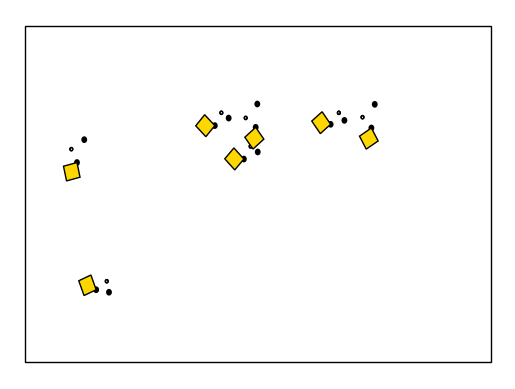

Initial positions reached
##### DEBUG OUTPUT #####
Your simulation will take approximately 53 real seconds when deployed on the Robotarium. 

	 Simulation had 510 iteration(s) where robots collided.



<Figure size 640x480 with 0 Axes>

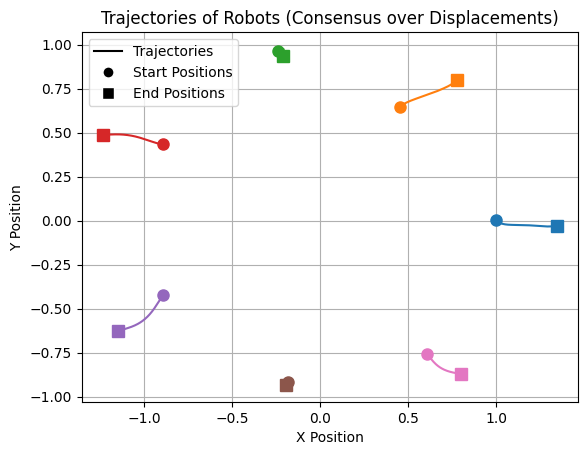

In [3]:
# Import necessary Robotarium utilities and other libraries
import numpy as np
from rps.robotarium import Robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.controllers import *
from rps.utilities.misc import *
import matplotlib.pyplot as plt  # Import for visualization

# Number of agents
N = 7
dt = 0.01  # Numerical step length
max_iter = 1000
videoFlag = False  # Change to True to record video
circularInitialConditions = True  # Change to False for random initial conditions

# Initialize the Robotarium object
rbtm = Robotarium(number_of_robots=N, show_figure=True)

# Create single integrator to unicycle dynamics mapping and barrier certificates
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Formation control parameters
formation_control_gain = 10
max_vel = 0.1  # Maximum velocity for safety

# Initialize robots' positions
xuni = rbtm.get_poses()  # States of real unicycle robots
x = xuni[:2, :]  # x-y positions only

# Assign dummy zero velocity
rbtm.set_velocities(np.arange(N), np.zeros((2, N)))
rbtm.step()

# Define formation weights based on desired distances
W = np.zeros((N, N))

# Desired distances between connected agents
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# Initialize positions on a circle if required
if circularInitialConditions:
    angles = np.linspace(0, 2 * np.pi * (1 - 1 / N), N)
    circularTargets = np.vstack((np.cos(angles), np.sin(angles)))
    errorToInitialPos = x - circularTargets
    errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
    while np.max(errorNorm) > 0.05:
        # Update state variables
        xuni = rbtm.get_poses()
        x = xuni[:2, :]
        # Update errors
        errorToInitialPos = x - circularTargets
        errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
        # Compute control inputs
        u = -0.3 * errorToInitialPos
        # Limit the maximum velocity
        norms = np.linalg.norm(u, axis=0)
        idxs_to_normalize = (norms > max_vel)
        u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]
        # Map single integrator velocities to unicycle velocities
        dx = si_to_uni_dyn(u, xuni)
        # Assign new control inputs to robots
        rbtm.set_velocities(np.arange(N), dx)
        rbtm.step()
    print('Initial positions reached')

# Define adjacency matrix based on formation weights
Adj = (W > 0)

# Initialize array to record positions
positions = np.zeros((2, N, max_iter))

# Main loop for formation control
for k in range(max_iter):
    # Get new data and initialize new null velocities
    xuni = rbtm.get_poses()  # Get new robots' states
    x = xuni[:2, :]  # Extract single integrator states
    u = np.zeros((2, N))  # Initialize velocities to zero

    # Record positions at this time step
    positions[:, :, k] = x

    # Formation control algorithm
    for i in range(N):
        neighbors = np.where(Adj[i, :])[0]
        for j in neighbors:
            # Compute the error between agent i and its neighbor j
            error = x[:, j] - x[:, i]
            distance_error = np.linalg.norm(error) ** 2 - W[i, j] ** 2
            u[:, i] += formation_control_gain * distance_error * error

    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]

    # Use barrier certificates to avoid collisions
    u = si_barrier_cert(u, x)

    # Convert single integrator inputs to unicycle inputs
    dx = si_to_uni_dyn(u, xuni)

    # Assign new control inputs to robots and update
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()

# Call at the end of the script
rbtm.call_at_scripts_end()

# Visualization of trajectories
plt.figure()

# Initialize legend handles and labels
legend_elements = []

for i in range(N):
    # Plot trajectory
    plt.plot(positions[0, i, :], positions[1, i, :], color=f"C{i}", label=f'Robot {i+1}')
    # Plot start position
    start_plot, = plt.plot(positions[0, i, 0], positions[1, i, 0], marker='o', color=f"C{i}", markersize=8, linestyle='None')
    # Plot end position
    end_plot, = plt.plot(positions[0, i, -1], positions[1, i, -1], marker='s', color=f"C{i}", markersize=8, linestyle='None')

    # Add to legend elements only once
    if i == 0:
        legend_elements.append(start_plot)
        legend_elements.append(end_plot)

# Create custom legend
trajectory_legend = plt.Line2D([0], [0], color='black', label='Trajectories')
start_legend = plt.Line2D([0], [0], marker='o', color='w', label='Start Positions',
                          markerfacecolor='black', markersize=8, linestyle='None')
end_legend = plt.Line2D([0], [0], marker='s', color='w', label='End Positions',
                        markerfacecolor='black', markersize=8, linestyle='None')

plt.legend(handles=[trajectory_legend, start_legend, end_legend])

plt.title('Trajectories of Robots (Consensus over Displacements)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()



#### d) Minimally adjust the formation graph above as needed so that agents converge to the desired shape when starting from initial positions located on the circle. Do they still converge when starting from random initial condition?


For $N = 7$, a minimally rigid graph requires:

\begin{align*}
2N - 3 = 2 \times 7 - 3 = 11 \text{ edges}
\end{align*}

The original graph has only **7 edges**, which is **insufficient** for minimal rigidity.

---

### Adjusting the Formation Graph

To achieve **minimal rigidity**, we need to **add 4 additional edges** to the original formation graph, bringing the total to **11 edges**.

#### Added Edges


1. **Edge \( \{2,6\} \)**: Connects Agent 2 to Agent 6.
2. **Edge \( \{3,5\} \)**: Connects Agent 3 to Agent 5.
3. **Edge \( \{2,7\} \)**: Connects Agent 2 to Agent 7.
4. **Edge \( \{2,5\} \)**: Connects Agent 2 to Agent 5.

#### Updated Formation Edges $E_f^\prime$

\begin{align*}
E_f^\prime = E_f \cup \{ \{2,6\},\ \{3,5\},\ \{2,7\},\ \{2,5\} \}
\end{align*}

**Total Number of Edges:** 11



#### Demonstration of $E_f^\prime$

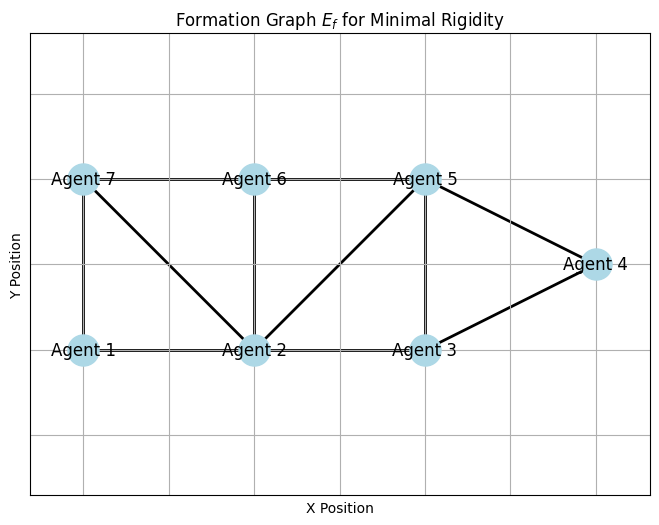

In [10]:
import numpy as np
import networkx as nx

# Number of agents
N = 7

# Initialize adjacency matrix W
W = np.zeros((N, N))

# Define the desired positions of the agents (Agents 1 to 7)
positions = {
    0: (1, 1),    # Agent 1
    1: (2, 1),    # Agent 2
    2: (3, 1),    # Agent 3
    3: (4, 1.5),  # Agent 4
    4: (3, 2),    # Agent 5
    5: (2, 2),    # Agent 6
    6: (1, 2)     # Agent 7
}

# Desired distances for original edges
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# New edges to achieve minimal rigidity
W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
W[2, 4] = W[4, 2] = 1               # Agents 3 and 5

# Create adjacency matrix (binary)
Adj = (W > 0).astype(int)

# Create a NetworkX graph from adjacency matrix
G = nx.Graph()
G.add_nodes_from(range(N))
edges = np.transpose(np.nonzero(np.triu(Adj)))
G.add_edges_from([tuple(edge) for edge in edges])

# Plotting the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, positions, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, positions, edgelist=edges, width=2)
nx.draw_networkx_labels(G, positions, labels={i: f'Agent {i+1}' for i in range(N)}, font_size=12)

# Set plot limits
x_values = [positions[i][0] for i in positions]
y_values = [positions[i][1] for i in positions]
plt.xlim(min(x_values) - 1, max(x_values) + 1)
plt.ylim(min(y_values) - 1, max(y_values) + 1)

plt.title('Formation Graph $E_f$ for Minimal Rigidity')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()

### Convergence from Circular Initial Positions (with the agent ordered from 1 to 7 on the circle)

* Starting from a circle with order from agent 1 to 7 provides direct path without local minimum toward the desired shape, allowing the formation control protocol to effectively minimize inter-agent distance errors.
  
* The added edges eliminate unwanted degrees of freedom, ensuring that the robots can only adjust their positions to match the desired formation without unintended flexing or rotation.


### Convergence from Random Initial Conditions

* When robots start from random initial positions, the minimally rigid formation graph does not guarantee convergence to the desired shape.

* While the formation graph is minimally rigid, it is not globally rigid. Global rigidity ensures that the formation shape is uniquely determined (up to translation and rotation) by the inter-agent distances.

* The distance-based control law may lead the formation to settle into a local minimum where inter-agent distances are satisfied, but the overall shape differs from the desired formation.

### Code for convergence from circular initial positions on minimally rigid graph: desired shape can be reached.

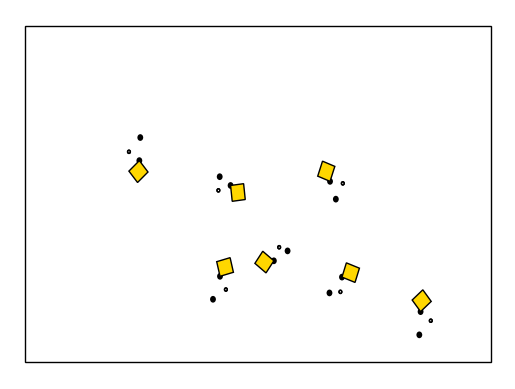

Initial positions reached
##### DEBUG OUTPUT #####
Your simulation will take approximately 50 real seconds when deployed on the Robotarium. 

	 Simulation had 510 iteration(s) where robots collided.



<Figure size 640x480 with 0 Axes>

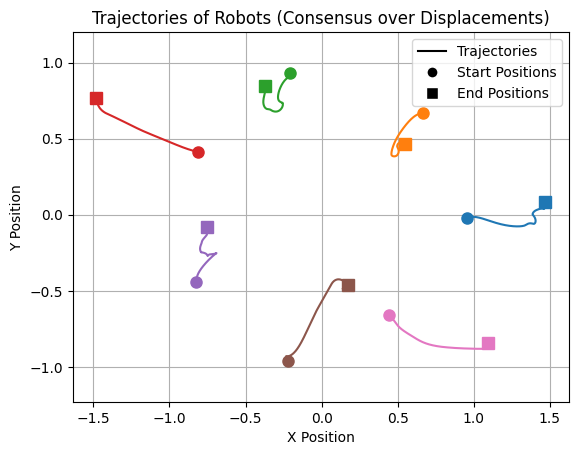

In [4]:
# Import necessary Robotarium utilities and other libraries
import numpy as np
from rps.robotarium import Robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.controllers import *
from rps.utilities.misc import *
import matplotlib.pyplot as plt  # Import for visualization

# Number of agents
N = 7
dt = 0.01  # Numerical step length
max_iter = 1000
videoFlag = False  # Change to True to record video
circularInitialConditions = True  # Change to False for random initial conditions

# Initialize the Robotarium object
rbtm = Robotarium(number_of_robots=N, show_figure=True)

# Create single integrator to unicycle dynamics mapping and barrier certificates
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Formation control parameters
formation_control_gain = 10
max_vel = 0.1  # Maximum velocity for safety

# Initialize robots' positions
xuni = rbtm.get_poses()  # States of real unicycle robots
x = xuni[:2, :]  # x-y positions only

# Assign dummy zero velocity
rbtm.set_velocities(np.arange(N), np.zeros((2, N)))
rbtm.step()

# Update formation weights W

# Original edges (indices adjusted for zero-based indexing)
W = np.zeros((N, N))

# Desired distances for original edges
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# New edges to achieve minimal rigidity
W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
W[2, 4] = W[4, 2] = 1               # Agents 3 and 5

# Update adjacency matrix Adj
Adj = (W > 0)

# Initialize positions on a circle or random positions
if circularInitialConditions:
    angles = np.linspace(0, 2 * np.pi * (1 - 1 / N), N)
    initial_positions = np.vstack((np.cos(angles), np.sin(angles)))
else:
    initial_positions = np.random.rand(2, N) * 2 - 1  # Random positions in [-1, 1]

# Move robots to initial positions
errorToInitialPos = x - initial_positions
errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
while np.max(errorNorm) > 0.05:
    # Update state variables
    xuni = rbtm.get_poses()
    x = xuni[:2, :]
    # Update errors
    errorToInitialPos = x - initial_positions
    errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
    # Compute control inputs
    u = -0.3 * errorToInitialPos
    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]
    # Map single integrator velocities to unicycle velocities
    dx = si_to_uni_dyn(u, xuni)
    # Assign new control inputs to robots
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()
print('Initial positions reached')

# Initialize array to record positions
positions = np.zeros((2, N, max_iter))

# Main loop for formation control
for k in range(max_iter):
    # Get new data and initialize new null velocities
    xuni = rbtm.get_poses()  # Get new robots' states
    x = xuni[:2, :]  # Extract single integrator states
    u = np.zeros((2, N))  # Initialize velocities to zero

    # Record positions at this time step
    positions[:, :, k] = x

    # Formation control algorithm
    for i in range(N):
        neighbors = np.where(Adj[i, :])[0]
        for j in neighbors:
            # Compute the error between agent i and its neighbor j
            error = x[:, j] - x[:, i]
            distance_error = np.linalg.norm(error) ** 2 - W[i, j] ** 2
            u[:, i] += formation_control_gain * distance_error * error

    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]

    # Use barrier certificates to avoid collisions
    u = si_barrier_cert(u, x)

    # Convert single integrator inputs to unicycle inputs
    dx = si_to_uni_dyn(u, xuni)

    # Assign new control inputs to robots and update
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()

# Call at the end of the script
rbtm.call_at_scripts_end()

# Visualization of trajectories
plt.figure()

# Initialize legend handles and labels
legend_elements = []

for i in range(N):
    # Plot trajectory
    plt.plot(positions[0, i, :], positions[1, i, :], color=f"C{i}", label=f'Robot {i+1}')
    # Plot start position
    start_plot, = plt.plot(positions[0, i, 0], positions[1, i, 0], marker='o', color=f"C{i}", markersize=8, linestyle='None')
    # Plot end position
    end_plot, = plt.plot(positions[0, i, -1], positions[1, i, -1], marker='s', color=f"C{i}", markersize=8, linestyle='None')

    # Add to legend elements only once
    if i == 0:
        legend_elements.append(start_plot)
        legend_elements.append(end_plot)

# Create custom legend
trajectory_legend = plt.Line2D([0], [0], color='black', label='Trajectories')
start_legend = plt.Line2D([0], [0], marker='o', color='w', label='Start Positions',
                          markerfacecolor='black', markersize=8, linestyle='None')
end_legend = plt.Line2D([0], [0], marker='s', color='w', label='End Positions',
                        markerfacecolor='black', markersize=8, linestyle='None')

plt.legend(handles=[trajectory_legend, start_legend, end_legend])

plt.title('Trajectories of Robots (Consensus over Displacements)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()


### Code demonstrating random initial conditions do not guarantee convergence to the desired shape since the graph is only minimally rigid.

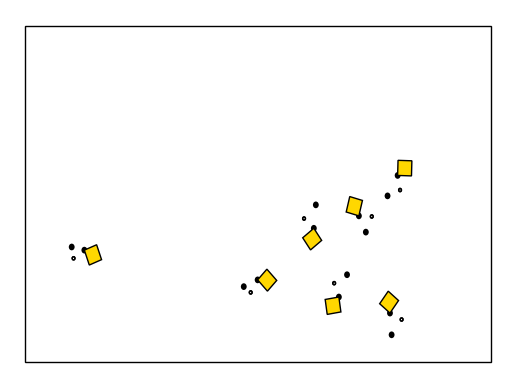

Initial positions reached
##### DEBUG OUTPUT #####
Your simulation will take approximately 55 real seconds when deployed on the Robotarium. 

	 Simulation had 510 iteration(s) where robots collided.



<Figure size 640x480 with 0 Axes>

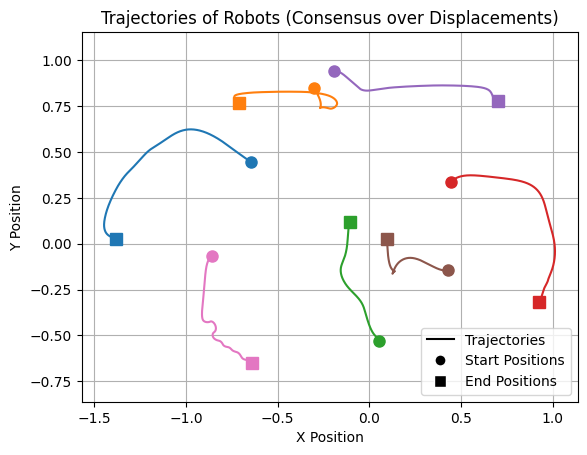

In [5]:
# Import necessary Robotarium utilities and other libraries
import numpy as np
from rps.robotarium import Robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.controllers import *
from rps.utilities.misc import *
import matplotlib.pyplot as plt  # Import for visualization

# Number of agents
N = 7
dt = 0.01  # Numerical step length
max_iter = 1000
videoFlag = False  # Change to True to record video
circularInitialConditions = False  # Change to False for random initial conditions

# Initialize the Robotarium object
rbtm = Robotarium(number_of_robots=N, show_figure=True)

# Create single integrator to unicycle dynamics mapping and barrier certificates
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Formation control parameters
formation_control_gain = 10
max_vel = 0.1  # Maximum velocity for safety

# Initialize robots' positions
xuni = rbtm.get_poses()  # States of real unicycle robots
x = xuni[:2, :]  # x-y positions only

# Assign dummy zero velocity
rbtm.set_velocities(np.arange(N), np.zeros((2, N)))
rbtm.step()

# Update formation weights W

# Original edges (indices adjusted for zero-based indexing)
W = np.zeros((N, N))

# Desired distances for original edges
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# New edges to achieve minimal rigidity
W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
W[2, 4] = W[4, 2] = 1               # Agents 3 and 5

# Update adjacency matrix Adj
Adj = (W > 0)

# Initialize positions on a circle or random positions
if circularInitialConditions:
    angles = np.linspace(0, 2 * np.pi * (1 - 1 / N), N)
    initial_positions = np.vstack((np.cos(angles), np.sin(angles)))
else:
    initial_positions = np.random.rand(2, N) * 2 - 1  # Random positions in [-1, 1]

# Move robots to initial positions
errorToInitialPos = x - initial_positions
errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
while np.max(errorNorm) > 0.05:
    # Update state variables
    xuni = rbtm.get_poses()
    x = xuni[:2, :]
    # Update errors
    errorToInitialPos = x - initial_positions
    errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
    # Compute control inputs
    u = -0.3 * errorToInitialPos
    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]
    # Map single integrator velocities to unicycle velocities
    dx = si_to_uni_dyn(u, xuni)
    # Assign new control inputs to robots
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()
print('Initial positions reached')

# Initialize array to record positions
positions = np.zeros((2, N, max_iter))

# Main loop for formation control
for k in range(max_iter):
    # Get new data and initialize new null velocities
    xuni = rbtm.get_poses()  # Get new robots' states
    x = xuni[:2, :]  # Extract single integrator states
    u = np.zeros((2, N))  # Initialize velocities to zero

    # Record positions at this time step
    positions[:, :, k] = x

    # Formation control algorithm
    for i in range(N):
        neighbors = np.where(Adj[i, :])[0]
        for j in neighbors:
            # Compute the error between agent i and its neighbor j
            error = x[:, j] - x[:, i]
            distance_error = np.linalg.norm(error) ** 2 - W[i, j] ** 2
            u[:, i] += formation_control_gain * distance_error * error

    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]

    # Use barrier certificates to avoid collisions
    u = si_barrier_cert(u, x)

    # Convert single integrator inputs to unicycle inputs
    dx = si_to_uni_dyn(u, xuni)

    # Assign new control inputs to robots and update
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()

# Call at the end of the script
rbtm.call_at_scripts_end()

# Visualization of trajectories
plt.figure()

# Initialize legend handles and labels
legend_elements = []

for i in range(N):
    # Plot trajectory
    plt.plot(positions[0, i, :], positions[1, i, :], color=f"C{i}", label=f'Robot {i+1}')
    # Plot start position
    start_plot, = plt.plot(positions[0, i, 0], positions[1, i, 0], marker='o', color=f"C{i}", markersize=8, linestyle='None')
    # Plot end position
    end_plot, = plt.plot(positions[0, i, -1], positions[1, i, -1], marker='s', color=f"C{i}", markersize=8, linestyle='None')

    # Add to legend elements only once
    if i == 0:
        legend_elements.append(start_plot)
        legend_elements.append(end_plot)

# Create custom legend
trajectory_legend = plt.Line2D([0], [0], color='black', label='Trajectories')
start_legend = plt.Line2D([0], [0], marker='o', color='w', label='Start Positions',
                          markerfacecolor='black', markersize=8, linestyle='None')
end_legend = plt.Line2D([0], [0], marker='s', color='w', label='End Positions',
                        markerfacecolor='black', markersize=8, linestyle='None')

plt.legend(handles=[trajectory_legend, start_legend, end_legend])

plt.title('Trajectories of Robots (Consensus over Displacements)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()


#### e) Finally, adjust again if needed the formation graph so that agents converge to the desired shape even when starting from random initial condition.

To achieve **global convergence** from any initial configuration, the formation graph must be **globally rigid**. Global rigidity ensures that the formation shape is uniquely determined by the inter-agent distances, eliminating ambiguities and preventing unintended flexing or rotations.

#### Characteristics of a Globally Rigid Formation in 2D:

A formation is globally rigid in 2D if it is (1) **rigid**, (2) **redundantly rigid**, and (3) **3-connected**.

* **Rigidity**: A formation is rigid if the rank of its rigidity matrix is larger than $2N - 3$.
* **Redundant Rigidity**: A formation is redundantly rigid if the removal of any single edge leaves the formation rigid.
* **3-connectivity**: A graph is 3-connected if removing any two vertices does not disconnect the graph.



### How to practically form a globally rigid formation in 2D?
* To ensure the three conditions are met, I write a small program to check whether a graph is rigid, redundantly rigid, and 3-connected.

* I use this code to verify whether adding a specific edge could contribute to global rigidity.

* Finally, I propose one specific formation edge $E_f^{\prime\prime}$ with a total of 12 edges that could achieve global rigidity, which is to add one more edge $\{1, 4\}$ into the minimally rigid edge set $E_f^\prime$:

\begin{align*}
E_f^{\prime\prime} = E_f^\prime \cup \{ \{1,4\} \} = E_f \cup \{ \{2,6\},\ \{3,5\},\ \{2,7\},\ \{2,5\},\ \{1,4\} \}
\end{align*}

### Code for verifying global rigidity with the proposed globally rigid formation.

The graph is rigid.
The graph is redundantly rigid.
The graph is 3-connected.
The graph is globally rigid in 2D.


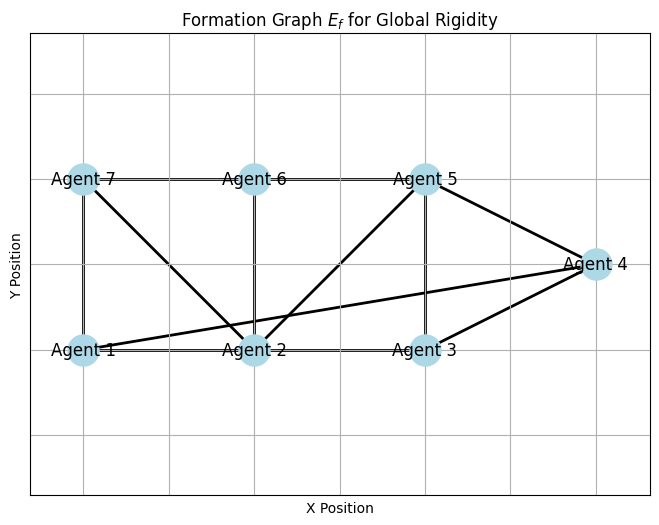

In [8]:
import numpy as np
import networkx as nx

# Number of agents
N = 7

# Initialize adjacency matrix W
W = np.zeros((N, N))

# Original edges
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# New edges to achieve minimal rigidity
W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
W[2, 4] = W[4, 2] = 1               # Agents 3 and 5
W[0, 3] = W[3, 0] = np.sqrt(9.25)   # Agents 1 and 4
#W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
#W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
#W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
#W[2, 4] = W[4, 2] = 1               # Agents 3 and 5
#W[0, 5] = W[5, 0] = np.sqrt(2)      # Agents 1 and 6
#W[2, 5] = W[5, 2] = np.sqrt(2)      # Agents 3 and 6
#W[0, 3] = W[3, 0] = np.sqrt(9.25)   # Agents 1 and 4

# Create adjacency matrix (binary)
Adj = (W > 0).astype(int)

# Create a NetworkX graph from adjacency matrix
G = nx.Graph()
G.add_nodes_from(range(N))
edges = np.transpose(np.nonzero(np.triu(Adj)))
G.add_edges_from([tuple(edge) for edge in edges])

def is_rigid(G, positions=None):
    N = len(G.nodes())
    edges = list(G.edges())
    e = len(edges)
    
    # If positions are not provided, use generic positions
    if positions is None:
        positions = np.random.rand(2, N)
    
    # Construct the rigidity matrix
    R = np.zeros((2 * e, 2 * N))
    for idx, (i, j) in enumerate(edges):
        xi, yi = positions[:, i]
        xj, yj = positions[:, j]
        R[2*idx, 2*i] = xi - xj
        R[2*idx, 2*i+1] = yi - yj
        R[2*idx, 2*j] = xj - xi
        R[2*idx, 2*j+1] = yj - yi
        R[2*idx+1, 2*i] = yi - yj
        R[2*idx+1, 2*i+1] = xj - xi
        R[2*idx+1, 2*j] = yj - yi
        R[2*idx+1, 2*j+1] = xi - xj
    
    # Compute the rank of the rigidity matrix
    rank = np.linalg.matrix_rank(R)
    # For 2D rigidity, the rank should be 2N - 3
    expected_rank = 2 * N - 3
    return rank >= expected_rank


def is_redundantly_rigid(G):
    # Check that the original graph is rigid
    if not is_rigid(G):
        return False
    
    # For each edge, remove it and check rigidity
    for edge in G.edges():
        H = G.copy()
        H.remove_edge(*edge)
        if not is_rigid(H):
            return False
    return True

def is_3_connected(G):
    return nx.node_connectivity(G) >= 3

# Check if the graph is rigid
if is_rigid(G):
    print("The graph is rigid.")
else:
    print("The graph is not rigid.")

# Check redundant rigidity
if is_redundantly_rigid(G):
    print("The graph is redundantly rigid.")
else:
    print("The graph is not redundantly rigid.")

# Check 3-connectivity
if is_3_connected(G):
    print("The graph is 3-connected.")
else:
    print("The graph is not 3-connected.")

# Determine global rigidity
if is_rigid(G) and is_redundantly_rigid(G) and is_3_connected(G):
    print("The graph is globally rigid in 2D.")
else:
    print("The graph is not globally rigid in 2D.")

# Define the desired positions of the agents (Agents 1 to 7)
positions = {
    0: (1, 1),    # Agent 1
    1: (2, 1),    # Agent 2
    2: (3, 1),    # Agent 3
    3: (4, 1.5),  # Agent 4
    4: (3, 2),    # Agent 5
    5: (2, 2),    # Agent 6
    6: (1, 2)     # Agent 7
}

# Plotting the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, positions, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, positions, edgelist=edges, width=2)
nx.draw_networkx_labels(G, positions, labels={i: f'Agent {i+1}' for i in range(N)}, font_size=12)

# Set plot limits
x_values = [positions[i][0] for i in positions]
y_values = [positions[i][1] for i in positions]
plt.xlim(min(x_values) - 1, max(x_values) + 1)
plt.ylim(min(y_values) - 1, max(y_values) + 1)

plt.title('Formation Graph $E_f$ for Global Rigidity')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()


### Using the above graph for formation control, we can achieve the desired shape no matter what initial contision is.

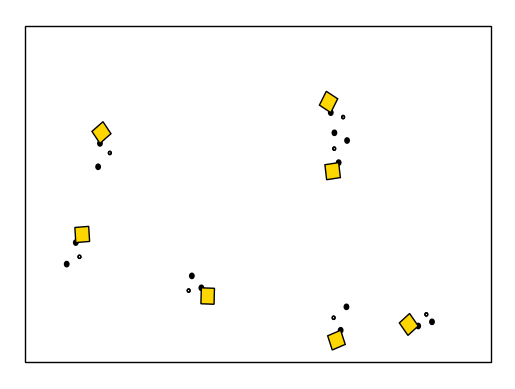

Initial positions reached
##### DEBUG OUTPUT #####
Your simulation will take approximately 57 real seconds when deployed on the Robotarium. 

	 Simulation had 645 iteration(s) where robots collided.



<Figure size 640x480 with 0 Axes>

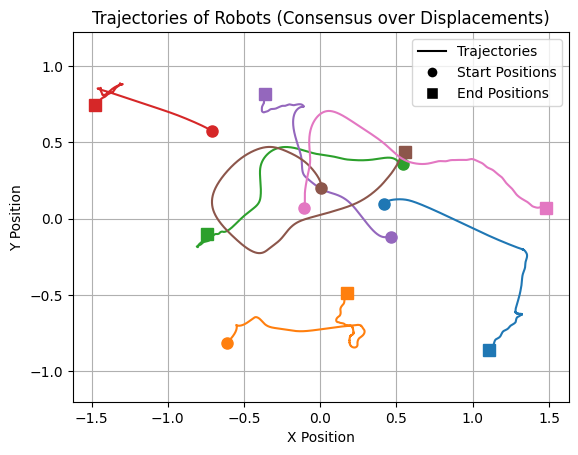

In [9]:
# Import necessary Robotarium utilities and other libraries
import numpy as np
from rps.robotarium import Robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.controllers import *
from rps.utilities.misc import *
import matplotlib.pyplot as plt  # Import for visualization

# Number of agents
N = 7
dt = 0.01  # Numerical step length
max_iter = 1000
videoFlag = False  # Change to True to record video
circularInitialConditions = False  # Change to False for random initial conditions

# Initialize the Robotarium object
rbtm = Robotarium(number_of_robots=N, show_figure=True)

# Create single integrator to unicycle dynamics mapping and barrier certificates
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Formation control parameters
formation_control_gain = 10
max_vel = 0.1  # Maximum velocity for safety

# Initialize robots' positions
xuni = rbtm.get_poses()  # States of real unicycle robots
x = xuni[:2, :]  # x-y positions only

# Assign dummy zero velocity
rbtm.set_velocities(np.arange(N), np.zeros((2, N)))
rbtm.step()

# Update formation weights W

# Original edges (indices adjusted for zero-based indexing)
W = np.zeros((N, N))

# Desired distances for original edges
W[0, 1] = W[1, 0] = 1          # Agents 1 and 2
W[1, 2] = W[2, 1] = 1          # Agents 2 and 3
W[2, 3] = W[3, 2] = np.sqrt(1.25)  # Agents 3 and 4
W[3, 4] = W[4, 3] = np.sqrt(1.25)  # Agents 4 and 5
W[4, 5] = W[5, 4] = 1          # Agents 5 and 6
W[5, 6] = W[6, 5] = 1          # Agents 6 and 7
W[6, 0] = W[0, 6] = 1          # Agents 7 and 1

# New edges to achieve global rigidity
W[1, 4] = W[4, 1] = np.sqrt(2)      # Agents 2 and 5
W[1, 6] = W[6, 1] = np.sqrt(2)      # Agents 2 and 7
W[1, 5] = W[5, 1] = 1               # Agents 2 and 6
W[2, 4] = W[4, 2] = 1               # Agents 3 and 5
W[0, 3] = W[3, 0] = np.sqrt(9.25)   # Agents 1 and 4

# Update adjacency matrix Adj
Adj = (W > 0)

# Initialize positions on a circle or random positions
if circularInitialConditions:
    angles = np.linspace(0, 2 * np.pi * (1 - 1 / N), N)
    initial_positions = np.vstack((np.cos(angles), np.sin(angles)))
else:
    initial_positions = np.random.rand(2, N) * 2 - 1  # Random positions in [-1, 1]

# Move robots to initial positions
errorToInitialPos = x - initial_positions
errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
while np.max(errorNorm) > 0.05:
    # Update state variables
    xuni = rbtm.get_poses()
    x = xuni[:2, :]
    # Update errors
    errorToInitialPos = x - initial_positions
    errorNorm = np.sum(errorToInitialPos ** 2, axis=0)
    # Compute control inputs
    u = -0.3 * errorToInitialPos
    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]
    # Map single integrator velocities to unicycle velocities
    dx = si_to_uni_dyn(u, xuni)
    # Assign new control inputs to robots
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()
print('Initial positions reached')

# Initialize array to record positions
positions = np.zeros((2, N, max_iter))

# Main loop for formation control
for k in range(max_iter):
    # Get new data and initialize new null velocities
    xuni = rbtm.get_poses()  # Get new robots' states
    x = xuni[:2, :]  # Extract single integrator states
    u = np.zeros((2, N))  # Initialize velocities to zero

    # Record positions at this time step
    positions[:, :, k] = x

    # Formation control algorithm
    for i in range(N):
        neighbors = np.where(Adj[i, :])[0]
        for j in neighbors:
            # Compute the error between agent i and its neighbor j
            error = x[:, j] - x[:, i]
            distance_error = np.linalg.norm(error) ** 2 - W[i, j] ** 2
            u[:, i] += formation_control_gain * distance_error * error

    # Limit the maximum velocity
    norms = np.linalg.norm(u, axis=0)
    idxs_to_normalize = (norms > max_vel)
    u[:, idxs_to_normalize] *= max_vel / norms[idxs_to_normalize]

    # Use barrier certificates to avoid collisions
    u = si_barrier_cert(u, x)

    # Convert single integrator inputs to unicycle inputs
    dx = si_to_uni_dyn(u, xuni)

    # Assign new control inputs to robots and update
    rbtm.set_velocities(np.arange(N), dx)
    rbtm.step()

# Call at the end of the script
rbtm.call_at_scripts_end()

# Visualization of trajectories
plt.figure()

# Initialize legend handles and labels
legend_elements = []

for i in range(N):
    # Plot trajectory
    plt.plot(positions[0, i, :], positions[1, i, :], color=f"C{i}", label=f'Robot {i+1}')
    # Plot start position
    start_plot, = plt.plot(positions[0, i, 0], positions[1, i, 0], marker='o', color=f"C{i}", markersize=8, linestyle='None')
    # Plot end position
    end_plot, = plt.plot(positions[0, i, -1], positions[1, i, -1], marker='s', color=f"C{i}", markersize=8, linestyle='None')

    # Add to legend elements only once
    if i == 0:
        legend_elements.append(start_plot)
        legend_elements.append(end_plot)

# Create custom legend
trajectory_legend = plt.Line2D([0], [0], color='black', label='Trajectories')
start_legend = plt.Line2D([0], [0], marker='o', color='w', label='Start Positions',
                          markerfacecolor='black', markersize=8, linestyle='None')
end_legend = plt.Line2D([0], [0], marker='s', color='w', label='End Positions',
                        markerfacecolor='black', markersize=8, linestyle='None')

plt.legend(handles=[trajectory_legend, start_legend, end_legend])

plt.title('Trajectories of Robots (Consensus over Displacements)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.show()


The desired shape is reached! 